In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
vgg19 = models.vgg19(pretrained=True).features[:29]
for param in vgg19.parameters():
    param.requires_grad_(False)

vgg19.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [4]:
def load_image(path, max_size=720, shape=None):
    image = Image.open(path).convert('RGB')

    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape

    im_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = im_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [5]:
# load in content and style image
content = load_image('images/peacock.jpg').to(device)
# Resize style to match content
style = load_image('images/starry_night.jpg', shape=content.shape[-2:]).to(device)

In [6]:
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

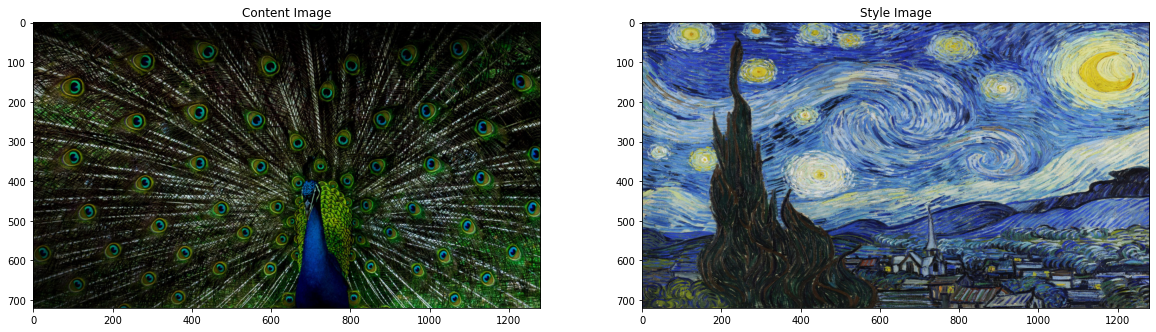

In [7]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax1.set_title("Content Image")
ax2.imshow(im_convert(style))
ax2.set_title("Style Image")
plt.show()
fig.savefig('images/content_style.png', bbox_align='tight')
plt.close()

In [8]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    ## Need the layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [9]:
def gram_matrix(tensor):
    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram

In [10]:
# get content and style features only once before training
content_features = get_features(content, vgg19)
style_features = get_features(style, vgg19)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start off with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

In [11]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta

Total loss:  308584768.0


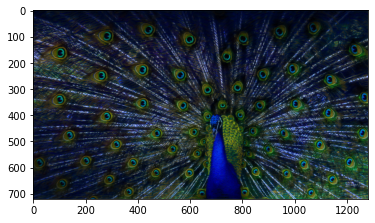

Total loss:  141692512.0


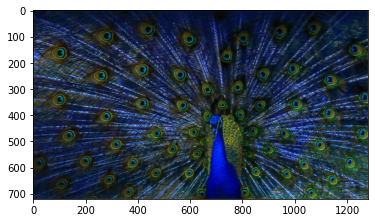

Total loss:  81615208.0


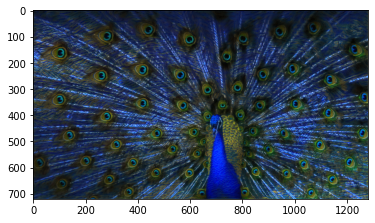

Total loss:  47584772.0


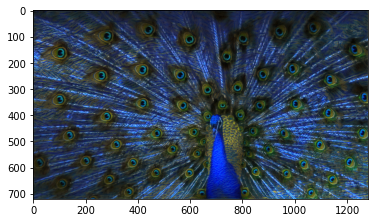

Total loss:  28080412.0


In [ ]:
# for displaying the target image, intermittently
show_every = 400

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 2000  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):
    
    # get the features from your target image
    target_features = get_features(target, vgg19)
    
    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

In [ ]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))
plt.show()
fig.savefig('images/style_transfer2.png', bbox_align='tight')
plt.close()

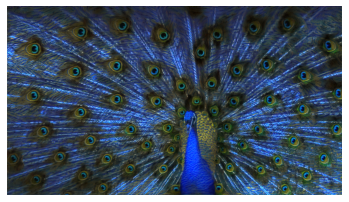

In [20]:
plt.axis('off')
plt.imshow(im_convert(target))
plt.savefig('images/gen_peacock.png', dpi=300, orientation='landscape', bbox_inches='tight', transparent=True, pad_inches=0)